# Subradar Point over Apophis

Agustin Vallejo

## Lo de Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls "/gdrive/MyDrive/Apophis/Data"

 AllRadiotelescopes.xlsx     observatory_distances_indexes.csv
 ephemeris2.xlsx	    'Radio coverage Arecibo Telescope.png'
 ephemeris3.xlsx	    'Radio coverage FAST.png'
 ephemeris.xlsx		    'Radio coverage Goldstone Radio Telescope.png'
 observatory_distances.csv   utils.ipynb


In [3]:
%cd "/gdrive/MyDrive/Apophis/Data"

/gdrive/MyDrive/Apophis/Data


In [4]:
import pandas as pd
import pylab as plt
import numpy as np

In [5]:
ephemeris = pd.read_excel("ephemeris.xlsx")
radio = pd.read_excel("AllRadiotelescopes.xlsx")
print(radio)

                                             Name  ...                                               Link
0                               Arecibo Telescope  ...                                                NaN
1                       Goldstone Radio Telescope  ...  https://en.wikipedia.org/wiki/Goldstone_Deep_S...
2                 Green Bank Interferometer (GBI)  ...                                                NaN
3                      Green Bank Telescope (GBT)  ...                                                NaN
4         Green Bank 140 Foot Telescope (140foot)  ...                                                NaN
5                          Very Large Array (VLA)  ...                                                NaN
6                 Very Long Baseline Array (VLBA)  ...                                                NaN
7                                            FAST  ...                                                NaN
8                                           CD

# Astropy

In [6]:
"ASTROPY"
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from astropy.modeling.rotations import RotationSequence3D
from astropy.constants import c
import astropy.units as u

In [7]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [280]:
# Obtains the Astropy Position Vector of given earth coordinates
pos = lambda x,h: EarthLocation(lon=x['Longitude']*u.deg,lat=x['Latitude']*u.deg,height=h*u.earthRad)

# Transforms an Astropy object into a simple 3-tuple vector
vec = lambda a:  (a.x.value,
                  a.y.value,
                  a.z.value)

# Returns the magnitude of a vector
dist = lambda v: np.linalg.norm(v)

# Returns the angle between two vectors in degrees
angle = lambda v1,v2: np.rad2deg( np.arccos( np.dot(v1,v2) / (dist(v1) * dist(v2)) ) )

def zenith_ecuat(obs, obs_time):
    """
    Obtains the coordinates of the observer's zenith at obs_time (jd)
    """
    zenith = SkyCoord(az=0*u.deg, alt=90*u.deg, distance=1*u.earthRad,
                      location=pos(obs,0), obstime=Time(obs_time, format='jd'), frame='altaz')
    return zenith.gcrs

def get_apo_to_earth(apo,obs,only_visible=True):
    """
    This function outputs the coordinates of an observatory as seen by Apophis.
    only_visible: If True, only returns points unobstructed by earth, invisible ones are None.
    If False, return all points.
    """
    # Apophis' coordinates
    apo_sky = SkyCoord(ra=apo['RA']*u.deg,dec=apo['DEC']*u.deg,
                       distance=apo['delta (Rt)']*u.earthRad)
    obs_time = Time(apo['datetime_jd'], format='jd')
    if obs:
        obs_zenith = zenith_ecuat(obs, obs_time)
        # Dot product to determine if there's visibility:
        dot = np.dot(vec(apo_sky.cartesian),vec(obs_zenith.cartesian))
        if only_visible and dot < 0:
            apo_to_obs = None
        apo_to_obs = SkyCoord(obs_zenith.cartesian - apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    else:
        apo_to_obs = SkyCoord(-apo_sky.cartesian, frame='gcrs', obstime=obs_time)
    return apo_to_obs

def new_coordinates_matrix():
    """
    Generates a rotation matrix with respect to Apophís moment of intertia
    https://ned.ipac.caltech.edu/coordinate_calculator?in_csys=Ecliptic&in_equinox=J2000.0&obs_epoch=2000.0&lon=250&lat=-75&pa=0.0&out_csys=Equatorial&out_equinox=J2000.0
    https://www.aanda.org/articles/aa/pdf/2018/09/aa32914-18.pdf
    """
    # NEW Z AXIS
    new_z = SkyCoord(ra=118.79*u.deg,dec=-79.4*u.deg,
                       distance=1*u.earthRad)
    new_z = vec(new_z.cartesian)
    new_z /= np.linalg.norm(new_z)

    # NEW X AXIS
    new_x = SkyCoord(ra=0*u.deg,dec=0*u.deg,
                       distance=1*u.earthRad)
    new_x = vec(new_x.cartesian)
    new_x = np.cross(new_z,new_x)
    new_x /= np.linalg.norm(new_x)

    # NEW Y AXIS
    new_y = np.cross(new_z,new_x)
    new_y /= np.linalg.norm(new_y)

    ROT = np.matrix([new_x,new_y,new_z])
    return ROT

def to_asteroid_coordinates(v_gcrs,t):
    v_subradar = to_subradar_coordinates(v_gcrs)
    v_subradar_rotated = rotate_asteroid(v_subradar,t)
    return v_subradar_rotated

def to_subradar_coordinates(v_gcrs):
    ROT = new_coordinates_matrix()
    v_subradar = np.matmul(ROT,vec(v_gcrs.cartesian))
    v_subradar = np.array(v_subradar).flatten()
    return SkyCoord(*v_subradar,representation_type='cartesian').gcrs

def rotate_asteroid(v_subradar,t):
    ROT = rotation_matrix(t)
    v_subradar_rotated = np.matmul(ROT,vec(v_subradar.cartesian))
    v_subradar_rotated = np.array(v_subradar_rotated).flatten()
    return SkyCoord(*v_subradar_rotated,representation_type='cartesian').gcrs

def rotation_matrix(t):
    omega = 2*np.pi/(27.38/24)
    theta = omega*t
    ROT = np.matrix([[np.cos(theta),np.sin(theta),0],
                     [-np.sin(theta),np.cos(theta),0],
                     [0,0,1]])
    return ROT

def get_subradar_points(ephemeris,obs):
    """
    This function iterates over the ephemeris to generate subradar points 
    for a specific observatory
    """
    output = {"date":[],
              "date_jd": [],
              "ra":[],
              "dec":[],
              "lon":[],
              "lat":[],
              "lonR":[],
              "latR":[]}

    date0 = ephemeris['datetime_jd'][ephemeris['delta (Rt)'].idxmin()]
    for r,row in ephemeris.iterrows():
        point = get_apo_to_earth(row,obs)
        if point:
            point_sub = to_subradar_coordinates(point)
            output['date'] += [row['datetime_str']]
            output['date_jd'] += [row['datetime_jd']]

            # ECUATORIAL COORDINATES OF OBSERVATORY FROM APOPHIS
            output['ra']   += [point.ra.value]
            output['dec']  += [point.dec.value]

            # LOCAL COORDINATES OF OBS FROM APOPHIS
            output['lat']  += [point_sub.dec.value]
            if point_sub.ra.value < 180:
                output['lon'] += [point_sub.ra.value]
            else:
                output['lon'] += [point_sub.ra.value - 360]

            # LOCAL COORDINATES OF OBS FROM APOPHIS APPLYING ROTATION
            t = row['datetime_jd'] - date0
            point_sub_rotated = rotate_asteroid(point_sub,t)
            output['latR']  += [point_sub_rotated.dec.value]
            if point_sub_rotated.ra.value < 180:
                output['lonR'] += [point_sub_rotated.ra.value]
            else:
                output['lonR'] += [point_sub_rotated.ra.value - 360]
    return output

In [246]:
# TEST CELL OF COORDINATE TRANSFORMATION
point = SkyCoord(ra=118.79*u.deg,dec=-79.4*u.deg,
                       distance=1*u.earthRad) # THIS IN PARTICULAR IS THE POINTING VECTOR OF THE ASTEROID MOMENT OF INERTIA
rotate_asteroid(point,0)

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (118.81962957, -79.39820728)>

In [281]:
obs = radio.iloc[7]
obs = {'Name':"Earth's Center"}
subradar_points = pd.DataFrame(get_subradar_points(ephemeris,None))

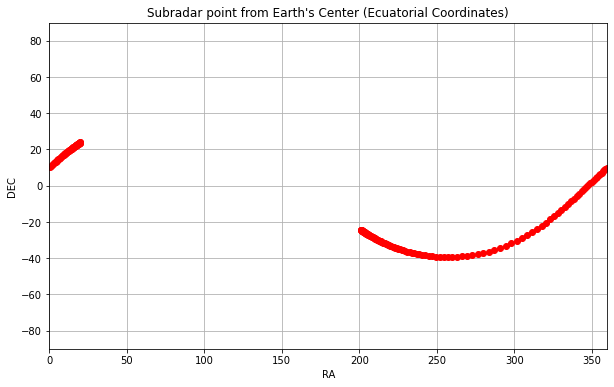

In [282]:
plt.figure(figsize=(10,6))
# plt.plot(180+ephemeris['RA'],-1*ephemeris['DEC'],'bo',label="Ecuatorial Coordinates of Earth from Apophis")
plt.plot(subradar_points.ra,subradar_points.dec,'ro',label="Ecuatorial Coordinates of Observatory from Apophis")
plt.xlim([0,360])
plt.ylim([-90,90])
# plt.legend()
plt.title("Subradar point from "+obs['Name'] + " (Ecuatorial Coordinates)")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.grid()

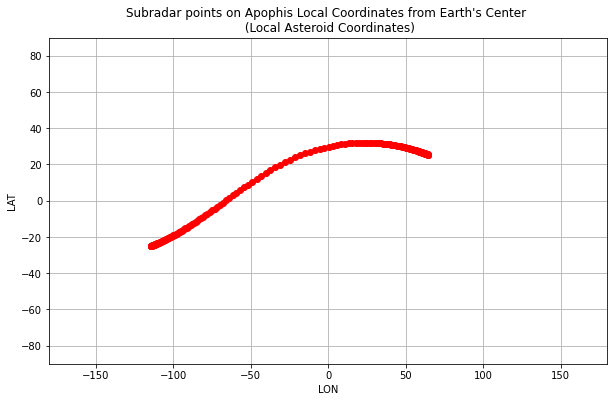

In [283]:
plt.figure(figsize=(10,6))
plt.plot(subradar_points.lon,subradar_points.lat,'ro')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.title("Subradar points on Apophis Local Coordinates from "+obs['Name']+" \n (Local Asteroid Coordinates)")
plt.xlabel("LON")
plt.ylabel("LAT")
plt.grid()

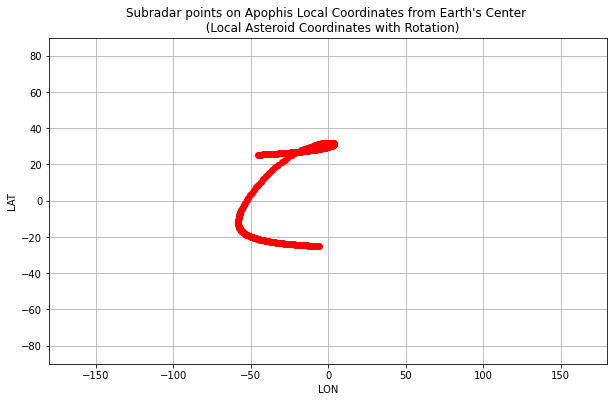

In [284]:
plt.figure(figsize=(10,6))
plt.plot(subradar_points.lonR,subradar_points.latR,'ro')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.title("Subradar points on Apophis Local Coordinates from "+obs['Name']+" \n  (Local Asteroid Coordinates with Rotation)")
plt.xlabel("LON")
plt.ylabel("LAT")
plt.grid()

In [285]:
subradar_points

,date,date_jd,ra,dec,lon,lat,lonR,latR
0,2029-Apr-13 13:30,2.462240e+06,20.17701,23.94602,-114.590194,-25.094418,-6.118579,-25.097152
1,2029-Apr-13 13:35,2.462240e+06,20.05465,23.87547,-114.453582,-25.047769,-7.077760,-25.050488
2,2029-Apr-13 13:40,2.462240e+06,19.93009,23.80346,-114.314466,-25.000088,-8.034434,-25.002791
3,2029-Apr-13 13:45,2.462240e+06,19.80327,23.72997,-114.172780,-24.951365,-8.988538,-24.954052
4,2029-Apr-13 13:50,2.462240e+06,19.67413,23.65493,-114.028450,-24.901544,-9.939998,-24.904212
...,...,...,...,...,...,...,...,...
195,2029-Apr-14 05:45,2.462241e+06,201.52165,-24.70663,63.922720,25.594497,-41.268510,25.595697
196,2029-Apr-14 05:50,2.462241e+06,201.39295,-24.63440,64.065894,25.547406,-42.221091,25.548571
197,2029-Apr-14 05:55,2.462241e+06,201.26684,-24.56342,64.206241,25.501060,-43.176497,25.502189
198,2029-Apr-14 06:00,2.462241e+06,201.14323,-24.49367,64.343855,25.455454,-44.134636,25.456548


In [286]:
# Given longitude and latitude angles in degrees, return cartesian representation
spherical = lambda lon,lat: (np.cos(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lon))*np.cos(np.deg2rad(lat)),
                             np.sin(np.deg2rad(lat)))

N_lons = 72
N_lats = 36
lons   = np.linspace(-180,180,N_lons)
lats   = np.linspace(-90,90,N_lats)

lon_grid, lat_grid = np.meshgrid(lons, lats)

def coverage(point):
    """
    Returns the meshgrid of all the radar coverage
    """
    out = np.zeros((N_lats,N_lons))
    for i in range(N_lons):
        for ii in range(N_lats):
            dot = np.dot(spherical(point.lonR, point.latR),
                         spherical(lons[i], lats[ii]))
            if dot > 0:
                out[ii,i] = 1
    return out

def full_coverage(subradar_points):
    out = np.zeros((N_lats,N_lons))
    for r, point in subradar_points.iterrows():
        out += coverage(point)
    # out /= np.max(out)
    return out

In [287]:
full_cov = full_coverage(subradar_points)

In [288]:
full_cov_norm = full_cov / len(ephemeris)

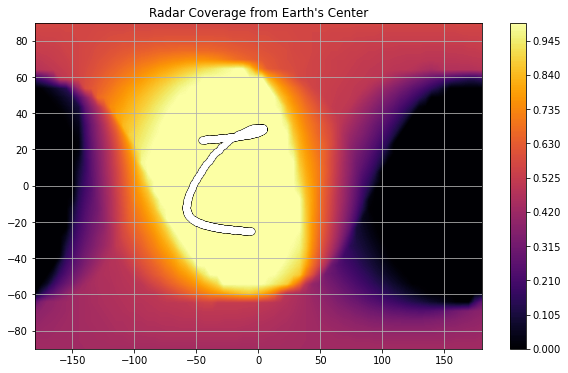

In [289]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111) #, projection = 'mollweide')
ax.set_title("Radar Coverage from "+obs['Name'])
axx = ax.contourf(lons, lats, full_cov_norm, cmap="inferno", levels=len(subradar_points))
ax.plot(subradar_points.lonR,subradar_points.latR,'ko',ms=7)
ax.plot(subradar_points.lonR,subradar_points.latR,'wo',ms=6)
ax.grid()
fig.colorbar(axx,ax=ax)
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [290]:
total_time = (ephemeris['datetime_jd'].iloc[-1]-ephemeris['datetime_jd'].iloc[0])*u.day.to(u.h)
total_time

full_cov_h = full_cov_norm*total_time

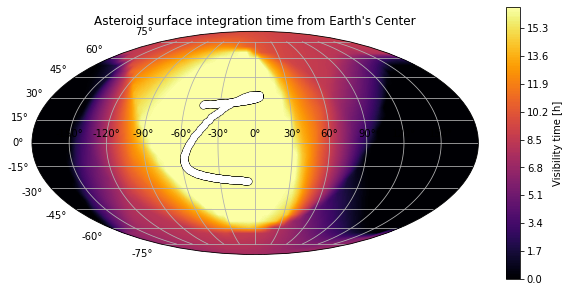

In [298]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time from "+obs['Name'])
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), full_cov_h, cmap="inferno", levels=len(subradar_points))
ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'ko',ms=7)
ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'wo',ms=6)
# ax.colorbar()
ax.grid()
fig.colorbar(axx,ax=ax, label="Visibility time [h]")
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [299]:
fig.savefig("Radio coverage %s.png"%obs['Name'])

In [300]:
threshold = 1/60 # h
covered = lambda x: 1 if x>threshold else 0

integrable = np.vectorize(covered)(full_cov_h)

In [301]:
len(subradar_points)

200

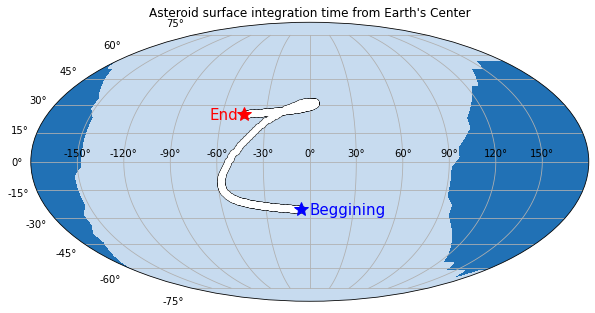

In [302]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111, projection = 'mollweide')
ax.set_title("Asteroid surface integration time from "+obs['Name'])
axx = ax.contourf(np.deg2rad(lons), np.deg2rad(lats), integrable, cmap="Blues_r", levels=1)
ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'ko',ms=7)
ax.plot(np.deg2rad(subradar_points.lonR),np.deg2rad(subradar_points.latR),'wo',ms=6)

last = len(subradar_points) - 1
ax.plot(np.deg2rad(subradar_points.lonR[0]),np.deg2rad(subradar_points.latR[0]),'b*',ms=15)
ax.plot(np.deg2rad(subradar_points.lonR[last]),np.deg2rad(subradar_points.latR[last]),'r*',ms=15)
ax.text(np.deg2rad(subradar_points.lonR[0])+0.1,np.deg2rad(subradar_points.latR[0])-0.05,"Beggining",color="blue", size=15)
ax.text(np.deg2rad(subradar_points.lonR[last])-0.4,np.deg2rad(subradar_points.latR[last])-0.05,"End",color="red",size=15)
# ax.colorbar()
ax.grid()
# ax.savefig("Radio coverage %s.png"%obs['Name'])

In [303]:
subradar_points.to_csv("subradar_points.csv")